In [1]:
using Revise

In [10]:
include("../src/bmparticles.jl")
include("../src/bmtheory.jl")
using .BParts
using .Theorist

In [3]:
using DifferentialEquations, Distributions, LaTeXStrings, ProgressMeter, LsqFit

In [4]:
using Plots
# plotly()
gr()


Plots.GRBackend()

## Fixed Density

First we compare the particle simulation with the simulations of the Langevin equation (and some analytical results from it) for a fixed population size.

When comparing the two we must take care to ensure both approaches are modeling the same system. In particular, a particle modeled by the Langevin equation has its future speed distribution initially determined by the energy of the system, as it is parameterized by $D/\gamma$ (see equation (3) in document) which can be equated to the average energy per particle $\left< E \right>$ (4); however in the simulation particles are introduced into the system with a speed rather than an energy. If the simulation is initiated with all particles having the same speed -- which is convenient to ensure the system evolves to the predetermined equilibrium, as opposed to drawing their speeds from the desired distribution in which case the system energy becomes a random variable -- we must ensure the average energy matches that of the Langevin particle. We know that
\begin{equation}
    \left< E \right> = \frac{\left< v^2 \right>}{2}
\end{equation}
thus using $\left< v_0^2 \right> = \left< s_0^2 \right> = s_0^2$ (since all particles have the same speed initially) we know that the initial particle speed and the average energy per particle are related through
\begin{align}
    s_0 = \sqrt{2\left< E \right>} \\
    \left< E \right> = \frac{s_0^2}{2}
\end{align}
Note that as the system evolves the particle speeds should become distributed according to the Rayleigh distribution, and the average speed becomes
\begin{equation}
    \left< s \right> = \sqrt{E} \sqrt{\frac{\pi}{2}}
\end{equation}

### Parameters for simulation

In [5]:
function extendParams!(arenaParams::Dict)
    bounds = arenaParams["bounds"]
    arenaParams["volume"] = abs(bounds[1][2]-bounds[1][1])*abs(bounds[2][2]-bounds[2][1])
    arenaParams["bperiod"] = [abs(bounds[1][2]-bounds[1][1]), abs(bounds[2][2]-bounds[2][1])]
end

extendParams! (generic function with 1 method)

In [72]:
arenaParams = 
    Dict(
        "n0"=>300,
        "evolveTime"=>3000,
        "timeStep"=> 0.05,
        "bounds"=>((0.,10.),(0.,10.)), 
        "radius"=>0.08, 
        "speed"=>0.02
    )

extendParams!(arenaParams)
for p in arenaParams
    println(p)
end

waitTime = 1500
timeSteps = arenaParams["timeStep"]:arenaParams["timeStep"]:arenaParams["evolveTime"]

display(arenaParams)

function fillDensity(arenaParams)  
    xperiod = abs(arenaParams["bounds"][1][2] - arenaParams["bounds"][1][1])
    yperiod = abs(arenaParams["bounds"][2][2] - arenaParams["bounds"][2][1])
    n0 = arenaParams["n0"]
    r = arenaParams["radius"]
    V = xperiod*yperiod
    fillDens = n0*π*r^2 / V
    return fillDens
end

println("surface covered: ", fillDensity(arenaParams))

Dict{String,Any} with 8 entries:
  "volume"     => 100.0
  "evolveTime" => 3000
  "speed"      => 0.02
  "radius"     => 0.08
  "timeStep"   => 0.05
  "bounds"     => ((0.0, 10.0), (0.0, 10.0))
  "bperiod"    => [10.0, 10.0]
  "n0"         => 300

Pair{String,Any}("volume", 100.0)
Pair{String,Any}("evolveTime", 3000)
Pair{String,Any}("speed", 0.02)
Pair{String,Any}("radius", 0.08)
Pair{String,Any}("timeStep", 0.05)
Pair{String,Any}("bounds", ((0.0, 10.0), (0.0, 10.0)))
Pair{String,Any}("bperiod", [10.0, 10.0])
Pair{String,Any}("n0", 300)
surface covered: 0.060318578948924034


In [73]:
thermVals = Theorist.thermalValues(arenaParams)


Dict{Any,Any} with 8 entries:
  "γ"         => 0.0240636
  "ρ"         => 0.0603186
  "σc"        => 0.32
  "D"         => 4.81273e-6
  "l"         => 0.73657
  "E"         => 0.0002
  "DiffCoeff" => 0.0083113
  "n"         => 3.0

### Simulations

run a particle simulation:

In [74]:
arena, pos_t_dim_id, vel_t_dim_id, cells_T_ID = 
    BParts.randArenaEvolve(arenaParams["n0"], arenaParams["evolveTime"], arenaParams["timeStep"], arenaParams; 
        verbose=true, overlapScans=200, attempts = 10)

println("energy per cell: ",
        BParts.kineticEnergy(arena) / arenaParams["n0"]
    )



Building arena...
22 overlaps fixed. Making another pass...
6 overlaps fixed. Making another pass...
1 overlaps fixed. Making another pass...
1 overlaps fixed. Making another pass...
1 overlaps fixed. Making another pass...
1 overlaps fixed. Making another pass...
No overlaps found.
Arena succesfully built


Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:00

energy per cell: 0.00019999999999999982


Run an ensemble of Langevin equations:

In [9]:
@time langevinEnsemble = Theorist.runLangevinSims(5000, arenaParams);

Energy: 0.0002
135.815634 seconds (3.59 G allocations: 63.471 GiB, 10.63% gc time)


In [75]:
nSims = 50
pos_Sim = Array{Array{Union{Float64, Missing},3}}(undef, nSims)
@showprogress for i in 1:nSims
    succes = false
    while !succes 
        # try/catch construction in case boundserror occurs
        try
            _, posSim_t_dim_id, __, ___ = 
                BParts.randArenaEvolve(arenaParams["n0"], 
                    arenaParams["evolveTime"], 
                    arenaParams["timeStep"], 
                    arenaParams;
                    progress=false, verbose=false)
            pos_Sim[i] = posSim_t_dim_id
#             println("sim: ", i)
        catch e
            println("fail")
            continue 
        end
        succes = true
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:54:58


In [76]:
msdTimes = (waitTime, arenaParams["evolveTime"])
timesPMSD_t = msdTimes[1]:msdTimes[2]

msd_Sim = Array{Array{Float64}}(undef, nSims)
@showprogress for i in 1:nSims
    msd_Sim[i] = BParts.meanSquaredDisplacement(pos_Sim[i], msdTimes)
end

msdAv_t = Array{Float64, 1}(undef, length(timesPMSD_t))
for i in 1:length(timesPMSD_t)
    msdAv_t[i] = mean([ msd_tt[i] for msd_tt in msd_Sim ])
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


In [77]:
msdTimes_t = timesPMSD_t .- timesPMSD_t[1]

linModel(x, p) = p[1] .+ 4*p[2].*x

linFit_Sim = []
diffD_sim = Float64[]
for i in 1:nSims
    fit = curve_fit(linModel, msdTimes_t, msd_Sim[i], [0, 4*thermVals["DiffCoeff"]]);
    push!(linFit_Sim, fit)
    push!(diffD_sim, coef(fit)[2])
end

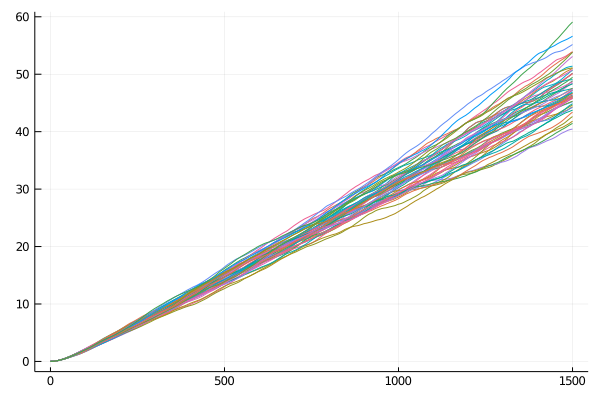

In [78]:
p3 = plot(msdTimes_t, msd_Sim[1],label="")
for i in 1:nSims
    plot!(msdTimes_t, msd_Sim[i], label="")
end

display(p3)

# plot!(timesPMSD_t, linModel(timesPMSD_t, coef(fit)))

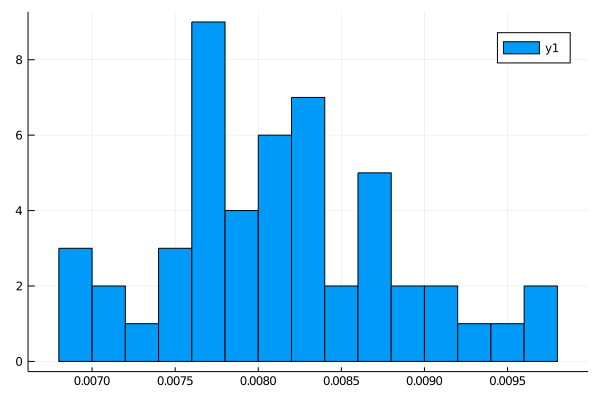

In [79]:
p4 = histogram(diffD_sim, bins=20)

In [80]:
thermVals["DiffCoeff"]

0.008311297508363182

In [82]:
diffDpart = mean(diffD_sim)

0.00814915819142953

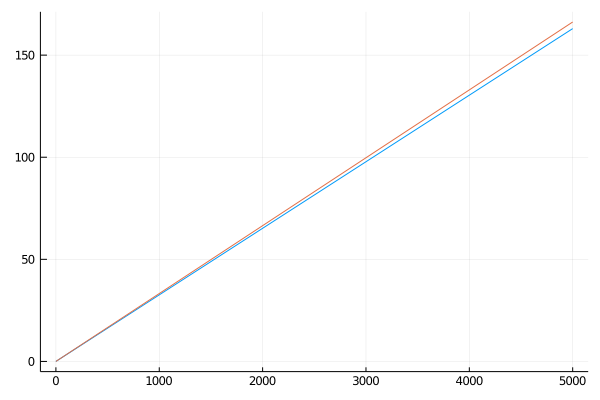

In [89]:
plot(0:5000, linModel(0:5000, [0, diffDpart]),
    label="")
plot!(0:5000, linModel(0:5000, [0, thermVals["DiffCoeff"]]),
    label="")